# Project - Airline AI Assistant


In [2]:
#imports

import os
import json
from dotenv import load_dotenv
from openai import OpenAI
import gradio as gr

In [4]:
# Initialization

load_dotenv(override=True)

openai_api_key = os.getenv('OPENAI_API_KEY')
if openai_api_key:
    print(f"OpenAI API Key exists and begins {openai_api_key[:8]}")
else:
    print("OpenAI API Key not set")

MODEL = "gpt-4o-mini"
openai = OpenAI()

OpenAI API Key exists and begins sk-proj-


In [5]:
system_message = "You are a helpful assistant for an Airline called FlightAI."
system_message += "Give short, curteous answers, no more than 1 sentence. "
system_message += "Always be accurate. If you don't know the answer, say so."

In [6]:
def chat(message, history):
    messages = [{"role": "system", "content": system_message}] + history + [{"role": "user", "content": message}]
    response = openai.chat.completions.create(model=MODEL, messages=messages)
    return response.choices[0].message.content

gr.ChatInterface(fn=chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7870
* To create a public link, set `share=True` in `launch()`.


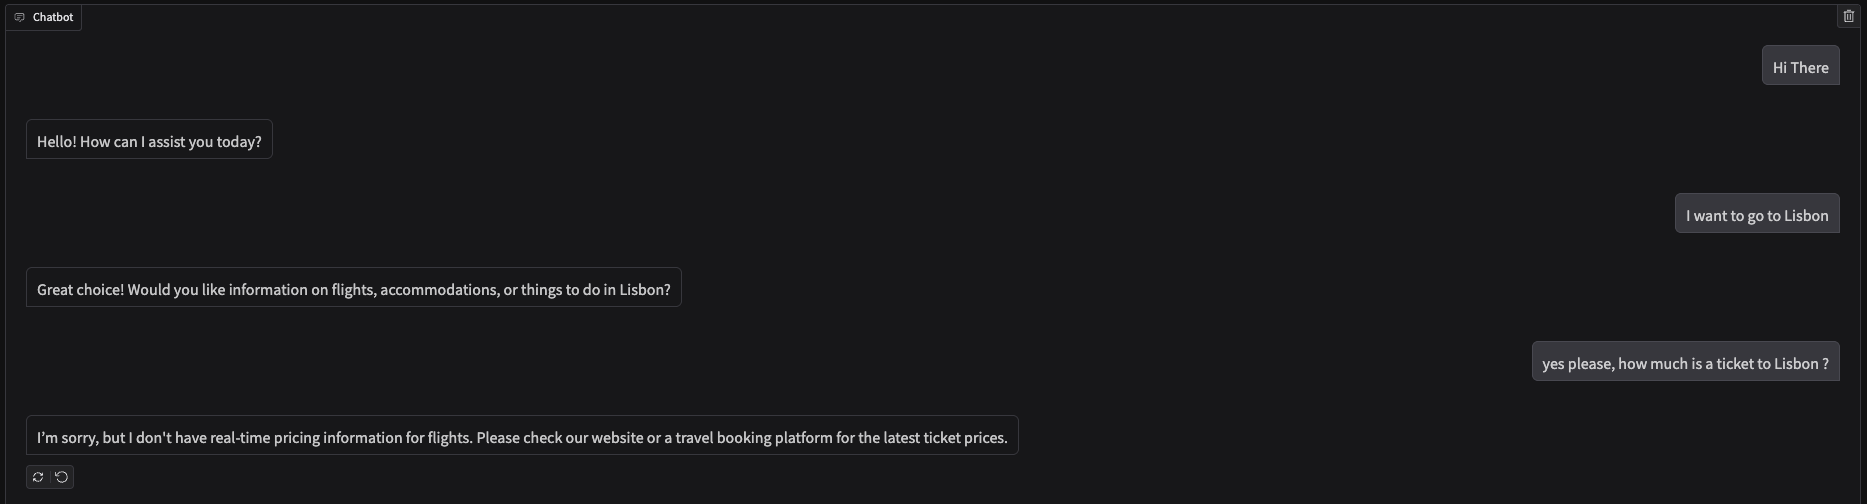

as you can see from the screenshot, it's simple and doesn't hallucinate anything and so far we haven't used any tools yet to provide the information the customer is looking for.

## Tools

Tools are an incredibly powerful feature provided by the frontier LLMs.

With tools, you can write a function, and have the LLM call that function as part of its response.

In [7]:
# Let's start by making a useful function

ticket_prices = {"london": "$799", "paris": "$899", "tokyo": "$1400", "berlin": "$499", "lisbon": "$449"}

def get_ticket_price(destination_city):
    print(f"Tool get_ticket_price called for {destination_city}")
    city = destination_city.lower()
    return ticket_prices.get(city, "Unknown")



In [10]:
get_ticket_price("london")

Tool get_ticket_price called for london


'$799'

In [15]:
# There's a particular dictionary structure that's required to describe our function:

price_function = {
    "name": "get_ticket_price",
    "description": (
        "Get the price of a return ticket to the destination city. "
        "Call this whenever you need to know the ticket price, for example when a "
        "customer asks 'How much is a ticket to this city'."
    ),
    "parameters": {
        "type": "object",
        "properties": {
            "destination_city": {
                "type": "string",
                "description": "The city that the customer wants to travel to",
            },
        },
        "required": ["destination_city"],
        "additionalProperties": False,
    },
}

{'name': 'get_ticket_price', 'description': "Get the price of a return ticket to the destination city. Call this whenever you need to know the ticket price, for example when a customer asks 'How much is a ticket to this city'.", 'parameters': {'type': 'object', 'properties': {'destination_city': {'type': 'string', 'description': 'The city that the customer wants to travel to'}}, 'required': ['destination_city'], 'additionalProperties': False}}


In [18]:
# And this is included in a list of tools:

tools = [{"type": "function", "function": price_function}]

## Getting OpenAI to use our Tool

There's some fiddly stuff to allow OpenAI "to call our tool"

What we actually do is give the LLM the opportunity to inform us that it wants us to run the tool.

Here's how the new chat function looks:

In [22]:
def chat(message, history):
    messages = [{"role": "system", "content": system_message}] + history + [{"role": "user", "content": message}]
    response = openai.chat.completions.create(model=MODEL, messages=messages, tools=tools)

    if response.choices[0].finish_reason=="tool_calls":
        message = response.choices[0].message
        response, city = handle_tool_call(message)
        messages.append(message)
        messages.append(response)
        response = openai.chat.completions.create(model=MODEL, messages=messages)
    
    return response.choices[0].message.content
    

In [23]:
# We have to write that function handle_tool_call:

def handle_tool_call(message):
    tool_call = message.tool_calls[0]
    arguments = json.loads(tool_call.function.arguments)
    city = arguments.get('destination_city')
    price = get_ticket_price(city)
    response = {
        "role": "tool",
        "content": json.dumps({"destination_city": city, "price": price}),
        "tool_call_id": tool_call.id
    }
    return response, city

In [24]:
gr.ChatInterface(fn=chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7872
* To create a public link, set `share=True` in `launch()`.


Tool get_ticket_price called for Lisbon
Tool get_ticket_price called for Berlin
Tool get_ticket_price called for Paris
Tool get_ticket_price called for Porto


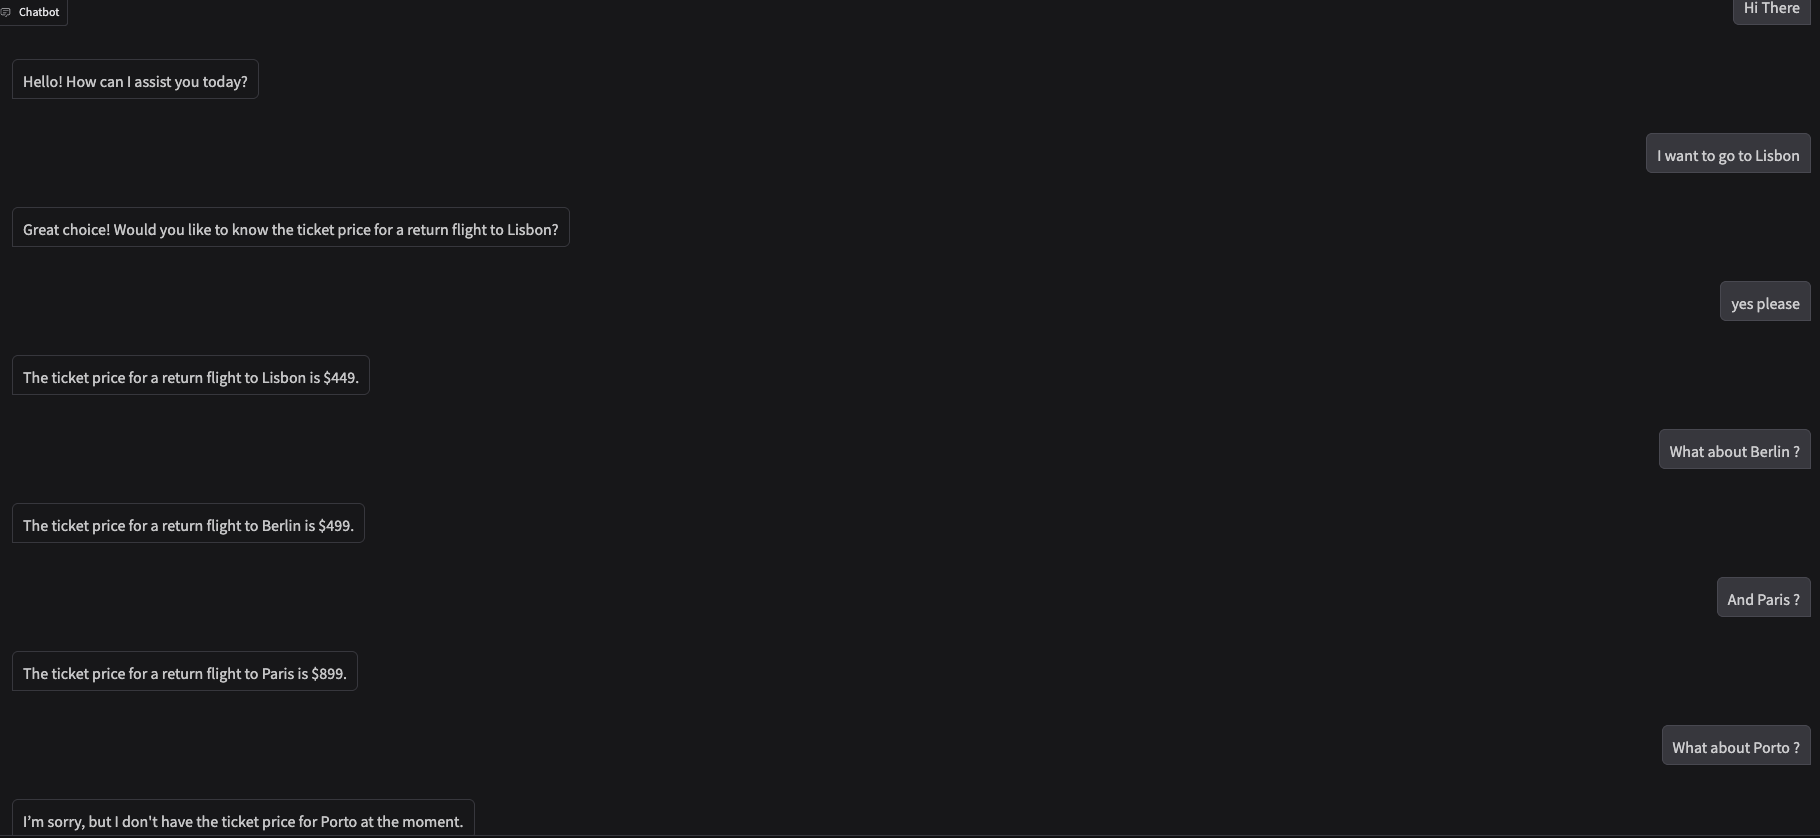

From the above screenshot we can see that our function is being called to fetch the results of Airline Flight ticket.

In the real world scrnario, this could be an exmaple where we would call the real api to fetch the results and provide it to the user, We could also add more for example different dates, availabilty of flights, stops in between, flight payment confirmation details api etc..

As we can see from the above Frontier models like gpt4 from OpenAI, claude from Anthropic have some powerful features that we can use out of the box to build some very useful tools.

# Let's go multi-modal!!

We can use DALL-E-3, the image generation model behind GPT-4o, to make us some images

Let's put this in a function called artists.


In [25]:
# some imports for handling images

import base64
from io import BytesIO
from PIL import Image

In [26]:
def artist(city):
    image_response = openai.images.generate(
        model = "dall-e-3",
        prompt = f"An image representing a vacation in {city}, showing tourists spots and everything unique about {city}, in a vibrant pop-art style",
        size="1024x1024",
        n=1,
        response_format = "b64_json",
    )
    image_base64 = image_response.data[0].b64_json
    image_data = base64.b64decode(image_base64)
    return Image.open(BytesIO(image_data))

In [ ]:
image = artist("New York City")
display(image)

## Audio 

And let's make a function talker that uses OpenAI's speech model to generate audio.



In [28]:
!ffmpeg -version
!ffprobe -version
!ffplay -version

ffmpeg version 7.1.1 Copyright (c) 2000-2025 the FFmpeg developers
built with Apple clang version 16.0.0 (clang-1600.0.26.6)
configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/7.1.1_4 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags='-Wl,-ld_classic' --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libharfbuzz --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex --e

In [35]:
from pydub import AudioSegment
from pydub.playback import play

def talker(message):
    response = openai.audio.speech.create(
        model="tts-1",
        voice="alloy",   #Also, try replacing alloy with onyx
        input=message
    )

    audio_stream = BytesIO(response.content)
    audio = AudioSegment.from_file(audio_stream, format="mp3")
    play(audio)

In [36]:
talker("Well, hi there")

Input #0, wav, from '/var/folders/_y/99y031352j57_sw95y_w7rm80000gn/T/tmpo87dl4ld.wav':
  Duration: 00:00:00.79, bitrate: 384 kb/s
  Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 24000 Hz, 1 channels, s16, 384 kb/s
   0.66 M-A:  0.000 fd=   0 aq=    0KB vq=    0KB sq=    0B 

   0.74 M-A:  0.000 fd=   0 aq=    0KB vq=    0KB sq=    0B 

# Our Agent Framework

The term 'Agentic AI' and Agentization is an umbrella term that refers to a number of techniques, such as:

1. Breaking a complex problem into smaller steps, with multiple LLMs carrying out specialized tasks.
2. The ability for LLMs to use Tools to give them additional capabilities.
3. The 'Agent Environment' which allows Agents to colllborate.
4. An LLM can act as the planner, dividing bigger tasks into smaller ones for the specialists.
5. The concept of an Agent having autonomy/agency, beyond just responding to a prompt - such as Memory.

We're seeing 1 and 2 here, and to a lesser extent 3 and 5.

In [39]:
def chat(history):
    messages = [{"role": "system", "content": system_message}] + history
    response = openai.chat.completions.create(model=MODEL, messages=messages, tools=tools)
    image = None

    if response.choices[0].finish_reason=="tool_calls":
        message = response.choices[0].message
        response, city = handle_tool_call(message)
        messages.append(message)
        messages.append(response)
        image = artist(city)
        response = openai.chat.completions.create(model=MODEL, messages=messages)

    reply = response.choices[0].message.content
    history += [{"role":"assistant", "content":reply}]

    # Comment out or delete teh next line if you'd rather skip Audio for now..
    talker(reply)

    return history, image

In [40]:
# More involved Gradio code as we're not using the present chat interface.
# Passing in inbrowser=True in the last line will cause a Gradio window to pop up immediately.

with gr.Blocks() as ui:
    with gr.Row():
        chatbot = gr.Chatbot(height=500, type="messages")
        image_output = gr.Image(height=500)
    with gr.Row():
        entry = gr.Textbox(label="Chat with our AI Assistant:")
    with gr.Row():
        clear = gr.Button("Clear")

    def do_entry(message, history):
        history += [{"role":"user", "content":message}]
        return "", history

    entry.submit(do_entry, inputs=[entry, chatbot], outputs=[entry, chatbot]).then(
        chat, inputs=chatbot, outputs=[chatbot, image_output]
    )
    clear.click(lambda: None, inputs=None, outputs=chatbot, queue=False)

ui.launch(inbrowser=True)

* Running on local URL:  http://127.0.0.1:7873
* To create a public link, set `share=True` in `launch()`.


Input #0, wav, from '/var/folders/_y/99y031352j57_sw95y_w7rm80000gn/T/tmpf1ckldzh.wav':
  Duration: 00:00:02.06, bitrate: 384 kb/s
  Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 24000 Hz, 1 channels, s16, 384 kb/s
   1.99 M-A: -0.000 fd=   0 aq=    0KB vq=    0KB sq=    0B 

Input #0, wav, from '/var/folders/_y/99y031352j57_sw95y_w7rm80000gn/T/tmp4adw58i5.wav':
  Duration: 00:00:02.57, bitrate: 384 kb/s
  Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 24000 Hz, 1 channels, s16, 384 kb/s
   2.50 M-A:  0.000 fd=   0 aq=    0KB vq=    0KB sq=    0B 


Tool get_ticket_price called for Lisbon


Input #0, wav, from '/var/folders/_y/99y031352j57_sw95y_w7rm80000gn/T/tmpucbd_ukd.wav':
  Duration: 00:00:05.42, bitrate: 384 kb/s
  Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 24000 Hz, 1 channels, s16, 384 kb/s
   5.33 M-A:  0.000 fd=   0 aq=    0KB vq=    0KB sq=    0B 

Input #0, wav, from '/var/folders/_y/99y031352j57_sw95y_w7rm80000gn/T/tmp3f6fzj29.wav':
  Duration: 00:00:04.15, bitrate: 384 kb/s
  Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 24000 Hz, 1 channels, s16, 384 kb/s
   4.06 M-A:  0.000 fd=   0 aq=    0KB vq=    0KB sq=    0B 

Input #0, wav, from '/var/folders/_y/99y031352j57_sw95y_w7rm80000gn/T/tmpbqlsbpk8.wav':
  Duration: 00:00:02.04, bitrate: 384 kb/s
  Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 24000 Hz, 1 channels, s16, 384 kb/s
   1.91 M-A:  0.000 fd=   0 aq=    0KB vq=    0KB sq=    0B 

Input #0, wav, from '/var/folders/_y/99y031352j57_sw95y_w7rm80000gn/T/tmp0rrgk13g.wav':
  Duration: 00:00:05.47, bitrate: 384 kb/s
  Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 24000 Hz, 1 channels, s16, 384 kb/s
   5.42 M-A: -0.000 fd=   0 aq=    0KB vq=    0KB sq=    0B 


Tool get_ticket_price called for Lisbon


Input #0, wav, from '/var/folders/_y/99y031352j57_sw95y_w7rm80000gn/T/tmplnucwbh4.wav':
  Duration: 00:00:05.59, bitrate: 384 kb/s
  Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 24000 Hz, 1 channels, s16, 384 kb/s
   5.48 M-A:  0.000 fd=   0 aq=    0KB vq=    0KB sq=    0B 

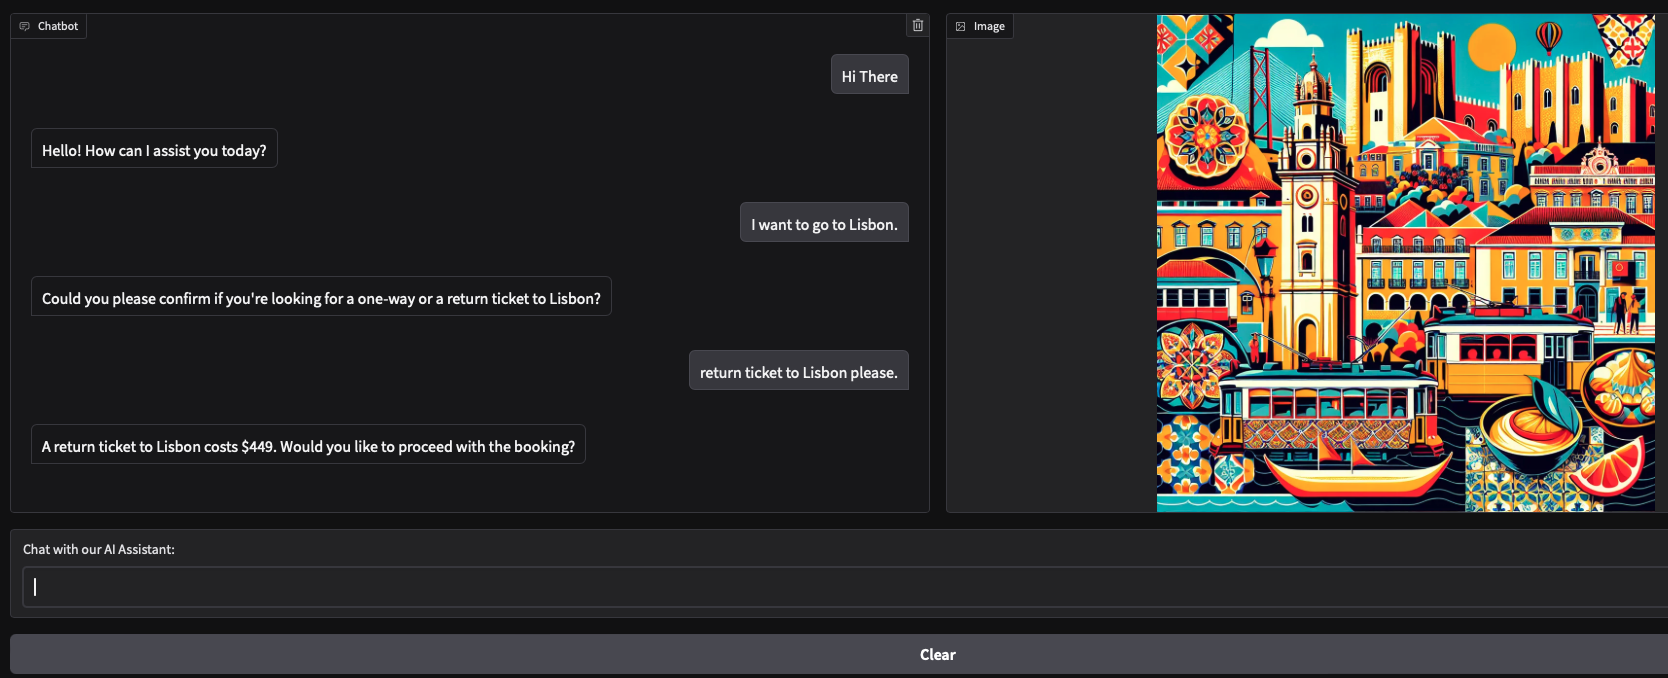

As you can see from the above screenshot, it generated a nice image of Lisbon along with the acurate information of the price ticket and also audio version of the text it generated.